***This notebook is built off of Germano's existing LSCP notebook:

***Objective:  Attempt to solve the Location Coverage Backup Problem as a script and access PuLP manually (outside of PySAL spopt ecosystem)

***Steps:
1)  Solve for LSCP

2)  Retrieve the minimum number of facilities required from LSCP result

3)  Assign this result to variable p and use for defining LpConstraint

In [1]:
from spopt.locate.coverage import LSCP, LSCPB
from spopt.locate.util import simulated_geo_points

import numpy
import geopandas
import pulp
import spaghetti
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [2]:
CLIENT_COUNT = 10 # quantity demand points
FACILITY_COUNT = 10 # quantity supply points

MAX_COVERAGE = 6 # maximum service radius in meters

# Random seeds for reproducibility
CLIENT_SEED = 5
FACILITY_SEED = 6

solver = pulp.PULP_CBC_CMD(msg=False, warmStart=True)

In [3]:
lattice = spaghetti.regular_lattice((0, 0, 10, 10), 9, exterior=True)
ntw = spaghetti.Network(in_data=lattice)

In [4]:
street = spaghetti.element_as_gdf(ntw, arcs=True)

street_buffered = geopandas.GeoDataFrame(
    geopandas.GeoSeries(street["geometry"].buffer(0.2).unary_union),
    crs=street.crs,
    columns=["geometry"],
)

<AxesSubplot:>

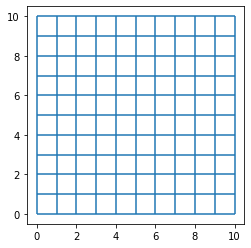

In [5]:
street.plot()

In [6]:
client_points = simulated_geo_points(street_buffered, needed=CLIENT_COUNT, seed=CLIENT_SEED)
facility_points = simulated_geo_points(
    street_buffered, needed=FACILITY_COUNT, seed=FACILITY_SEED
)

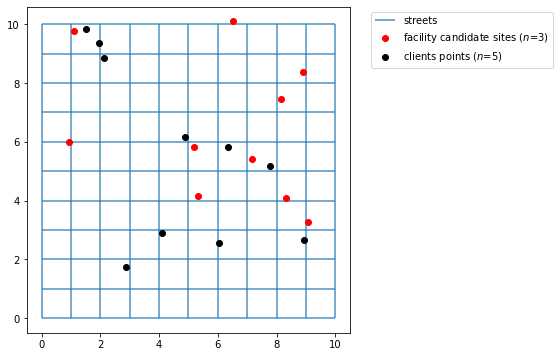

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))
street.plot(ax=ax, alpha=0.8, zorder=1, label='streets')
facility_points.plot(ax=ax, color='red', zorder=2, label='facility candidate sites ($n$=3)')
client_points.plot(ax=ax, color='black', label='clients points ($n$=5)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

In [8]:
ntw.snapobservations(client_points, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="clients", snapped=True
)

ntw.snapobservations(facility_points, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="facilities", snapped=True
)

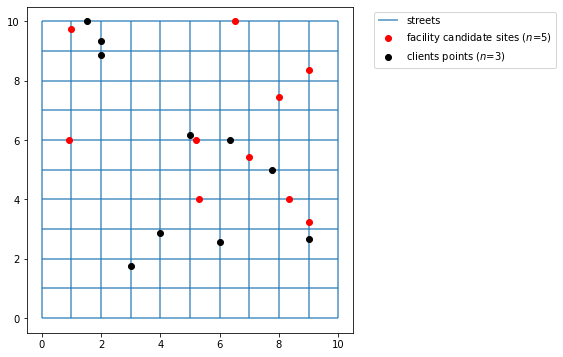

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
street.plot(ax=ax, alpha=0.8, zorder=1, label='streets')
facilities_snapped.plot(ax=ax, color='red', zorder=2, label='facility candidate sites ($n$=5)')
clients_snapped.plot(ax=ax, color='black', label='clients points ($n$=3)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

In [10]:
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)

In [11]:
cost_matrix

array([[12.60302601,  3.93598651,  8.16571655,  6.04319467,  5.65607701,
        11.18214123,  7.77728592,  7.39698689,  8.4298727 ,  1.90391589],
       [13.10096347,  4.43392397,  8.66365401,  6.54113213,  5.15813955,
        11.68007869,  7.98645534,  7.89492435,  8.92781016,  1.88691468],
       [ 6.9095462 ,  4.2425067 ,  2.47223674,  0.34971486,  5.34955682,
         5.48866142,  6.20496192,  4.29649292,  2.73639289,  7.5973957 ],
       [ 2.98196832,  7.84581224,  3.45534114,  3.57786302,  6.25374871,
         1.56108354,  4.60165639,  2.69318739,  1.19118499, 11.52497358],
       [ 7.5002892 ,  6.32806975,  4.55779979,  6.43527791, 11.75939222,
         7.57422447, 12.61479732, 10.70632832,  7.67344251, 10.00723109],
       [ 0.60209077, 11.42987132,  5.03940023,  7.16192211,  9.8378078 ,
         2.02297555,  5.71659889,  5.80812989,  4.77524408, 15.10903267],
       [ 5.37335867,  6.20113923,  2.43086927,  4.30834738,  9.6324617 ,
         5.44729395, 10.4878668 ,  8.5793978 

In [25]:
# create an array, mark values with a 1 if <= maximum coverage requirement
# all other values marked w/ zero (no coverage)
aij = numpy.zeros(cost_matrix.shape)
aij[cost_matrix <= MAX_COVERAGE] = 1
#! aij is the coverage matrix
aij

array([[0., 1., 0., 0., 1., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 1., 0., 0., 0., 0., 1.],
       [0., 1., 1., 1., 1., 1., 0., 1., 1., 0.],
       [1., 0., 1., 1., 0., 1., 1., 1., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 1., 1., 1., 1., 0.],
       [1., 0., 1., 1., 0., 1., 0., 0., 1., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [1., 0., 1., 1., 0., 1., 0., 0., 1., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0., 0., 1.]])

All code before this is really just setup... Now with the information we have how can we use the PuLP solver to solve for maximizing backup coverage.

First: Solve for LSCP <br>
Second: Use p (min # of facilities required) as the minimum required facilites in the LpProblem constraint.

In [27]:
lscp_from_cost_matrix = LSCP.from_cost_matrix(cost_matrix, MAX_COVERAGE)
lscp_from_cost_matrix.solve(solver)

In [30]:
#get the minimum number of facilities needed from result
p = lscp_from_cost_matrix.problem.objective.value()
p

2.0

In [32]:
#create a LSCPB object // solves lscp in the process
lscpb_from_cost_matrix = LSCPB.from_cost_matrix(cost_matrix, MAX_COVERAGE, solver)

#show LSCPB problem formulation
lscpb_from_cost_matrix.problem

LSCP-B:
MAXIMIZE
1*u_0_ + 1*u_1_ + 1*u_2_ + 1*u_3_ + 1*u_4_ + 1*u_5_ + 1*u_6_ + 1*u_7_ + 1*u_8_ + 1*u_9_ + 0
SUBJECT TO
_C1: x_0_ + x_1_ + x_2_ + x_3_ + x_4_ + x_5_ + x_6_ + x_7_ + x_8_ + x_9_ = 2

_C2: - u_0_ + x_1_ + x_4_ + x_9_ >= 1

_C3: - u_1_ + x_1_ + x_4_ + x_9_ >= 1

_C4: - u_2_ + x_1_ + x_2_ + x_3_ + x_4_ + x_5_ + x_7_ + x_8_ >= 1

_C5: - u_3_ + x_0_ + x_2_ + x_3_ + x_5_ + x_6_ + x_7_ + x_8_ >= 1

_C6: x_2_ >= 1

_C7: - u_5_ + x_0_ + x_2_ + x_5_ + x_6_ + x_7_ + x_8_ >= 1

_C8: - u_6_ + x_0_ + x_2_ + x_3_ + x_5_ + x_8_ >= 1

_C9: - u_7_ + x_0_ + x_1_ + x_2_ + x_3_ + x_4_ + x_5_ + x_6_ + x_7_ + x_8_
 >= 1

_C10: - u_8_ + x_0_ + x_2_ + x_3_ + x_5_ + x_8_ >= 1

_C11: - u_9_ + x_1_ + x_4_ + x_9_ >= 1

VARIABLES
0 <= u_0_ <= 1 Integer
0 <= u_1_ <= 1 Integer
0 <= u_2_ <= 1 Integer
0 <= u_3_ <= 1 Integer
0 <= u_4_ <= 1 Integer
0 <= u_5_ <= 1 Integer
0 <= u_6_ <= 1 Integer
0 <= u_7_ <= 1 Integer
0 <= u_8_ <= 1 Integer
0 <= u_9_ <= 1 Integer
0 <= x_0_ <= 1 Integer
0 <= x_1_ <= 1 Integer

In [35]:
# if LSCP is not infeasible, solve for LSCPB
lscpb_from_cost_matrix.solve(solver)

print('\n'+ 'Problem Status: ', lscpb_from_cost_matrix.problem.status)

# will need to create a function that compares the nested list items so demand nodes
# with backup coverage are easily identified
print('\n'+ 'Facility & Corresponding Demand Node Coverage:' + '\n', lscpb_from_cost_matrix.fac2cli)



Problem Status:  1

Facility & Corresponding Demand Node Coverage:
 [[], [0, 1, 2, 7, 9], [2, 3, 4, 5, 6, 7, 8], [], [], [], [], [], [], []]


Below is the original 'Manual' implementation of the LSCP-B for reference and cross-checking the solution

In [36]:
# create a LP problem with the method LpProblem in PuLP
#del(prob)
prob = pulp.LpProblem("LSCP-B", pulp.LpMaximize)

In [37]:
#how many clients
range_client = range(cost_matrix.shape[0])

#how many facilities
range_facility = range(cost_matrix.shape[1]) 

In [38]:
# create variables for the facilities, demand nodes, and coverage
fac_vars = [
    pulp.LpVariable(
        "facility_{}".format(i), lowBound=0, upBound=1, cat=pulp.LpInteger
    )
    for i in range_facility
]
print(fac_vars)

# coverage variable - this variable should be 1 anytime a demand node is covered > 1x
# i feel like this varibale should be created differently so that it is either assigned 0,1
# based on the coverage status of a demand node
cov_var = [
    pulp.LpVariable(
        "coverage_{}".format(i), lowBound=0, upBound=1, cat=pulp.LpInteger
    )
    for i in range_client
]
    
print(cov_var)

[facility_0, facility_1, facility_2, facility_3, facility_4, facility_5, facility_6, facility_7, facility_8, facility_9]
[coverage_0, coverage_1, coverage_2, coverage_3, coverage_4, coverage_5, coverage_6, coverage_7, coverage_8, coverage_9]


In [39]:
#minimum reqired coverage
coverage_min = 2

# this is still quite useful - it describes the relationship between facilities & demand nodes
'''for i in range_client:
    prob += (
        # I should understand the below line better // maybe have them reiterate for me?
        #!lpSum( [ int( aij[i][j] ) * fac_vars[j]  for j in range_facility ] ) >= 1 + cov_var[i]
        lpSum( [ int( aij[i][j] ) * fac_vars[j]  for j in range_facility ] ) >= 1 + cov_var[i]
    )'''

for i in range_client:
    if sum(aij[i]) >= coverage_min: # demand unit has meets coverage requirement
        prob += (
            pulp.lpSum( [ int( aij[i][j] ) * fac_vars[j]  for j in range_facility ] ) >= 1 + 1*cov_var[i]
        )
    else: #demand unit does not meet coverage requirement
        prob += (
            pulp.lpSum( [ int( aij[i][j] ) * fac_vars[j]  for j in range_facility ] ) >= 1 + 0*cov_var[i]
        )

prob += pulp.lpSum(1*i for i in cov_var), "objective function"

#constraints:
#  - the number of facilities chosen should be <= p
#  - all facilities should be either 0 or 1
#  - Ui should be <= 1 

# rhs – numerical value of constraint target, which should be == p from LSCP result
prob += pulp.LpConstraint(sum(fac_vars), sense=pulp.LpConstraintEQ, rhs=p, name='Facility Constraint')

print(prob)

LSCP-B:
MAXIMIZE
1*coverage_0 + 1*coverage_1 + 1*coverage_2 + 1*coverage_3 + 1*coverage_4 + 1*coverage_5 + 1*coverage_6 + 1*coverage_7 + 1*coverage_8 + 1*coverage_9 + 0
SUBJECT TO
_C1: - coverage_0 + facility_1 + facility_4 + facility_9 >= 1

_C2: - coverage_1 + facility_1 + facility_4 + facility_9 >= 1

_C3: - coverage_2 + facility_1 + facility_2 + facility_3 + facility_4
 + facility_5 + facility_7 + facility_8 >= 1

_C4: - coverage_3 + facility_0 + facility_2 + facility_3 + facility_5
 + facility_6 + facility_7 + facility_8 >= 1

_C5: facility_2 >= 1

_C6: - coverage_5 + facility_0 + facility_2 + facility_5 + facility_6
 + facility_7 + facility_8 >= 1

_C7: - coverage_6 + facility_0 + facility_2 + facility_3 + facility_5
 + facility_8 >= 1

_C8: - coverage_7 + facility_0 + facility_1 + facility_2 + facility_3
 + facility_4 + facility_5 + facility_6 + facility_7 + facility_8 >= 1

_C9: - coverage_8 + facility_0 + facility_2 + facility_3 + facility_5
 + facility_8 >= 1

_C10: - coverag

In [40]:
#solve the problem
print(type(prob))
prob.solve()
'''print('Coverage Values')   
for i in cov_var:
    print(i,i.varValue)'''

print('\n'+'Total Clients Covered >= 2 Times:', pulp.value(prob.objective))

print('\n'+ 'Chosen Facility Values')
for i in fac_vars:
    if i.varValue == 1:
        print(i,i.varValue)

<class 'pulp.pulp.LpProblem'>
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/pysaldev/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/fq/47y89n756hg5n9zwbqd79nhw0000gn/T/495a83fe1d1c4c8d8786c77a4fff03dc-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/fq/47y89n756hg5n9zwbqd79nhw0000gn/T/495a83fe1d1c4c8d8786c77a4fff03dc-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 16 COLUMNS
At line 135 RHS
At line 147 BOUNDS
At line 168 ENDATA
Problem MODEL has 11 rows, 20 columns and 68 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 3 - 0.00 seconds
Cgl0003I 12 fixed, 0 tightened bounds, 0 strengthened rows, 1 substitutions
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at

In [41]:
prob.status

1